In [24]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.optim.lr_scheduler import MultiStepLR
import matplotlib.pyplot as plt
import numpy as np 
import torchvision

In [25]:
batch_size = 128
transform = transforms.Compose(
    [transforms.ToTensor(),])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 48, kernel_size=3), nn.ReLU(),
        nn.Conv2d(48, 128, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(128, 96, kernel_size=1, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 10, kernel_size=1), 
        nn.AvgPool2d(kernel_size=8),
    )
  def forward(self, x):
    logits = self.net(x)
    return logits.view(-1, 10)

In [28]:
classifier = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet44", pretrained=True)
classifier = classifier.cuda()

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet44-2a3cabcb.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet44-2a3cabcb.pt


  0%|          | 0.00/2.62M [00:00<?, ?B/s]

In [29]:
def accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy: %s %%' % (100 * correct / total))

In [30]:
accuracy(classifier)

Accuracy: 91.31 %


In [31]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    layers = [
              nn.Conv2d(3, 64, 5, padding=2, stride=2), nn.BatchNorm2d(64, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(64, 128, 5, padding=2, stride=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(128, 256, 5, padding=2, stride=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Flatten(), nn.Linear(256*4*4, 2048), nn.BatchNorm1d(2048, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Linear(2048, 118),
    ]
    self.net = nn.Sequential(*layers)

  def forward(self,x):
    return self.net(x)

In [40]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
              nn.Linear(128, 256*4*4), nn.BatchNorm1d(256*4*4, momentum=0.9), nn.LeakyReLU(0.2),
              )
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(256,256,6, stride=2, padding=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(256,128,6, stride=2, padding=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128,32,6, stride=2, padding=2), nn.BatchNorm2d(32, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32,3,5, stride=1, padding=2), 
    )

  def forward(self, x):
    x = self.linear(x)
    x = x.view(-1, 256, 4, 4)
    return self.conv(x)

In [91]:
class Generator(nn.Module):
  def __init__(self, epsilon):
    super().__init__()
    self.decoder = Decoder()
    self.encoder = Encoder()
    self.classifier = classifier
    self.epsilon = epsilon
    for param in classifier.parameters():
      param.requires_grad = False

  def loss(self, x, y, gen_labels):
    one_hot = F.one_hot(gen_labels, 10).cuda()
    z = torch.cat((self.encoder(x), one_hot), 1)
    perturbation = torch.clamp(self.decoder(z), -epsilon, +epsilon)
    logits = self.classifier(x+perturbation)
    predictions = F.softmax(logits, 1)
    loss = nn.CrossEntropyLoss()
    ot_div = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
    return loss(classifier(x+perturbation), gen_labels) +  200 * ot_div(x.view(-1, 32, 32), (x+perturbation).view(-1, 32, 32)).mean(), perturbation

In [71]:
from geomloss import SamplesLoss

In [92]:
epsilon = 0.5
epochs = 20
model = Generator(epsilon).cuda()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
scheduler = MultiStepLR(optimizer, milestones=[10], gamma=0.1)

for epoch in range(epochs):
  for i, (x,y) in enumerate(train_loader):
    x,y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
    loss, perturbation = model.loss(x,y,gen_labels)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch+1, epochs, i+1, len(train_loader), loss.item()))

Epoch [1/20], Step [1/391], Loss: 583.9429931640625
Epoch [1/20], Step [101/391], Loss: 33.09786605834961
Epoch [1/20], Step [201/391], Loss: 21.01821517944336
Epoch [1/20], Step [301/391], Loss: 17.438251495361328
Epoch [2/20], Step [1/391], Loss: 16.738611221313477
Epoch [2/20], Step [101/391], Loss: 14.645063400268555
Epoch [2/20], Step [201/391], Loss: 13.769548416137695
Epoch [2/20], Step [301/391], Loss: 13.525468826293945
Epoch [3/20], Step [1/391], Loss: 12.239700317382812
Epoch [3/20], Step [101/391], Loss: 12.771268844604492
Epoch [3/20], Step [201/391], Loss: 11.466436386108398
Epoch [3/20], Step [301/391], Loss: 10.919744491577148
Epoch [4/20], Step [1/391], Loss: 11.496209144592285
Epoch [4/20], Step [101/391], Loss: 11.08127212524414
Epoch [4/20], Step [201/391], Loss: 11.03879165649414
Epoch [4/20], Step [301/391], Loss: 10.510235786437988
Epoch [5/20], Step [1/391], Loss: 9.910294532775879
Epoch [5/20], Step [101/391], Loss: 10.91547966003418
Epoch [5/20], Step [201/391

In [93]:
def adv_accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          gen_labels = torch.randint(0,10, (x.shape[0],)).cuda()
          outputs = net(model.loss(images, labels, gen_labels)[1] + images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Adversarial accuracy: %s %%' % (100 * correct / total))

In [94]:
adv_accuracy(classifier)

Adversarial accuracy: 53.14 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0.13189486
0.17571393
0.1323712
0.14354423
0.15332392
0.07446415
0.08764347
0.09722719
0.107357845
0.13576178
0.11163622
0.09493978
0.14862609
0.06348052
0.11366514
0.12646335
0.050948933
0.13518551
0.19933519
0.11184617
0.08905214
0.1481274
0.08399669
0.17471308


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0.10043108
0.11092078
0.13293576
0.12941387
0.16368058
0.07140226
0.1157564
0.15281287
0.098584384
0.09357587
0.12796316
0.07890728
0.10157831
0.14911327
0.09728612
0.10643644
0.16320069
0.11266981
0.1336183
0.07748759
0.29861292
0.1578349
0.07271863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

0.07793099
0.11893366
0.14268805
0.15833236
0.039815634
0.121954314
0.109062105
0.15161116
0.15383366
0.10010973
0.07101479
0.10746538
0.085331686
0.12398465
0.108502164
0.09421448
0.08418505


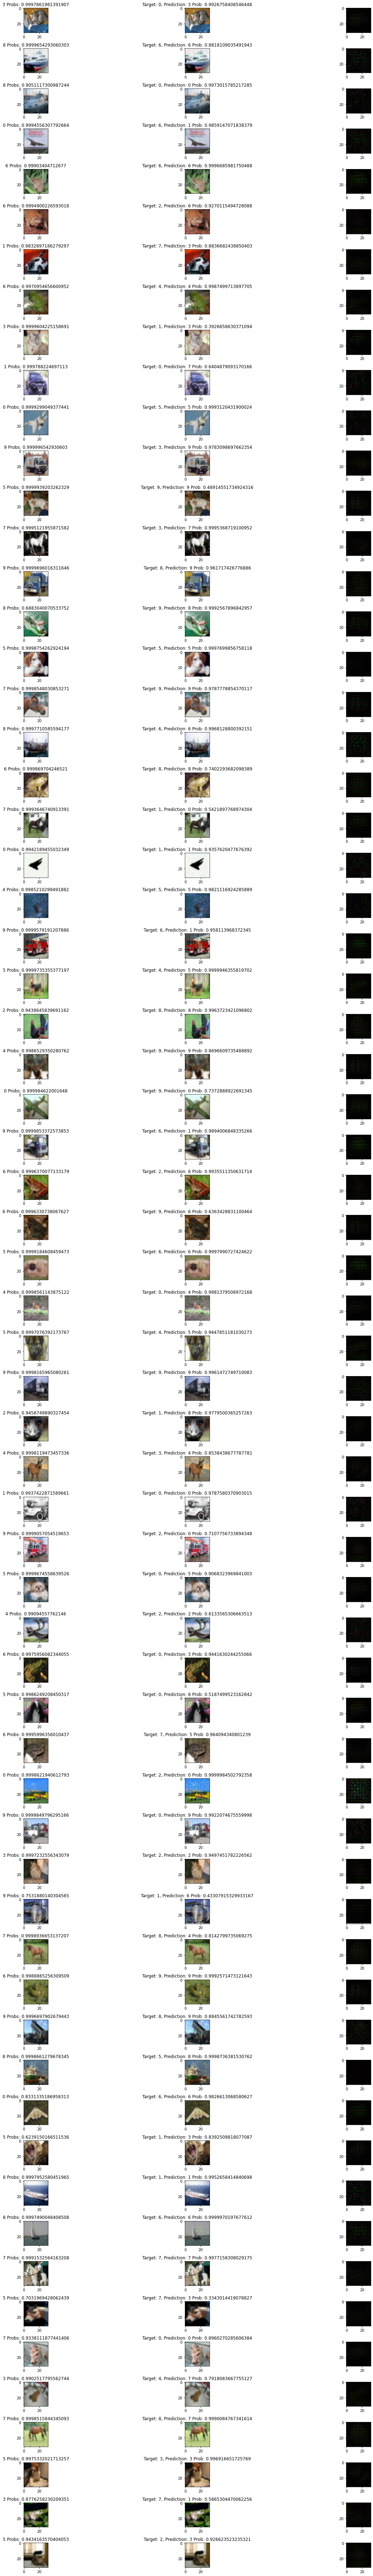

In [95]:
for x,y in test_loader:
  gen_labels = torch.randint(0,10, (128,)).cuda()
  x,y = x.cuda(), y.cuda()
  base_predictions = F.softmax(classifier(x), 1)
  _, perturbations = model.loss(x,y, gen_labels)
  new_predictions = F.softmax(classifier(x+perturbations), 1)
  fig, axs = plt.subplots(64, 3)
  fig.set_figheight(100)
  fig.set_figwidth(20)
  images = []
  for i in range(64):
          image, perturbation = x[i].detach().cpu().numpy().transpose(1,2,0), perturbations[i].detach().cpu().numpy().transpose(1,2,0)
          images.append(axs[i, 0].imshow(image))
          axs[i,0].title.set_text(f'{torch.argmax(base_predictions[i]).item()} Probs: {torch.max(base_predictions[i]).item()}')
          images.append(axs[i,1].imshow(image+perturbation))
          axs[i,1].title.set_text(f'Target: {gen_labels[i]}, Prediction: {torch.argmax(new_predictions[i]).item()} Prob: {torch.max(new_predictions[i]).item()}')
          images.append(axs[i,2].imshow(perturbation/epsilon, cmap='gray'))
          print(perturbation.max())
  break

plt.tight_layout()
plt.show()